## 결측치 제거 히트맵

<ipython-input-34-bbd94dd22ebd>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Origin'] = data['Origin'].replace(mapping)


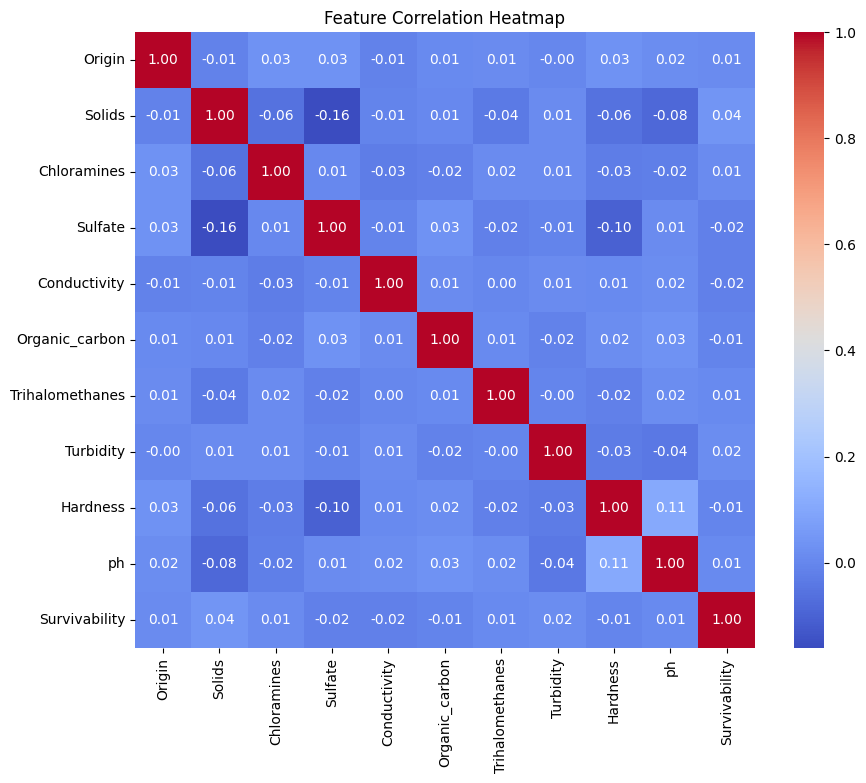

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('water_survive.csv')
mapping = {'river': 0, 'lake': 1, 'ocean': 2}
data['Origin'] = data['Origin'].replace(mapping)

# 결측값 제거
data_cleaned = data.dropna()

output_file_path = 'data_dropna.csv'
data.to_csv(output_file_path, index=False)
output_file_path

# 상관관계 히트맵
plt.figure(figsize=(10, 8))
correlation_matrix = data_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

## 데이터전처리

-Origin, Trihalomethanes는 결측값 비율이 5% 미만으로, 단순하게 최빈값과 중앙값을 사용해서 결측값을 채웠음.

-ph는 결측값 비율이 약 15%로 KNN Imputer로 결측값이 있는 샘플의 가장 가까운 이웃 데이터를 활용해 결측값을 보완하였음.

-sulfate는 결측값 비율이 23%로 높아서 단순한 채우기 방법보다는 다른 변수를 사용해 값을 예측하는 회귀모델을 적용하여 채웠음.

In [ ]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

data=pd.read_csv('water_survive.csv')

mapping = {'river': 0, 'lake': 1, 'ocean': 2}
data['Origin'] = data['Origin'].replace(mapping)

# Origin의 결측값을 최빈값으로 채우기
origin_imputer = SimpleImputer(strategy="most_frequent")
data["Origin"] = origin_imputer.fit_transform(data[["Origin"]])

# Trihalomethanes : 중앙값으로 채우기
median_imputer = SimpleImputer(strategy="median")
data["Trihalomethanes"] = median_imputer.fit_transform(data[["Trihalomethanes"]])

# ph : KNN Imputer로 채우기
knn_imputer = KNNImputer(n_neighbors=5)
data["ph"] = knn_imputer.fit_transform(data[["ph"]])

# Sulfate (회귀 기반 채우기)
sulfate_missing = data[data["Sulfate"].isnull()]
sulfate_not_missing = data[data["Sulfate"].notnull()]
# Sulfate를 타겟 변수로 설정
X = sulfate_not_missing.drop(columns=["Sulfate"])
y = sulfate_not_missing["Sulfate"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

X_missing = sulfate_missing.drop(columns=["Sulfate"])
sulfate_missing["Sulfate"] = regressor.predict(X_missing)

# 결측값 채운 데이터 합치기
data = pd.concat([sulfate_not_missing, sulfate_missing]).sort_index()

output_file_path = 'new.csv'

data.to_csv(output_file_path, index=False)

output_file_path


<ipython-input-20-e55cec92ea24>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Origin'] = data['Origin'].replace(mapping)
<ipython-input-20-e55cec92ea24>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sulfate_missing["Sulfate"] = regressor.predict(X_missing)


'new.csv'

### 모델

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

data=pd.read_csv('new.csv')

# 데이터 확인
print("Dataset Overview:")
mapping = {'river': 0, 'lake': 1, 'ocean': 2}
data['Origin'] = data['Origin'].replace(mapping)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
print(data.head())

# 'Survivability' 클래스 분포 확인
print("\nClass distribution in 'Survivability':")
print(data['Survivability'].value_counts())

X = data.drop(columns=["Survivability"])
y = data["Survivability"]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

Dataset Overview:
   Origin       Solids  Chloramines     Sulfate  Conductivity  Organic_carbon  \
0     0.0  20791.31898     7.300212  368.516441    564.308654       10.379783   
1     0.0  18630.05786     6.635246  344.058275    592.885359       15.180013   
2     1.0  19909.54173     9.275884  335.784806    418.606213       16.868637   
3     2.0  22018.41744     8.059332  356.886136    363.266516       18.436525   
4     1.0  17978.98634     6.546600  310.135738    398.410813       11.558279   

   Trihalomethanes  Turbidity    Hardness        ph  Survivability  
0         8.954468   2.963135  204.890456  7.080795              0  
1         4.048808   4.500656  129.422921  3.716080              0  
2         4.210943   3.055934  224.236259  8.099124              0  
3         9.236995   4.628771  214.373394  8.316766              0  
4         3.496447   4.075075  181.101509  9.092223              0  

Class distribution in 'Survivability':
Survivability
0    1998
1    1278
Name: c

In [ ]:
# Linear Regression 모델
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_linear_reg = linear_reg.predict(X_test)

y_pred_binary = np.where(y_pred_linear_reg > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred_binary)
print("\nLinear Regression Report")
print(classification_report(y_test, y_pred_binary))
print(f"Accuracy: {accuracy:.2f}")


Linear Regression Report
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       400
           1       0.00      0.00      0.00       256

    accuracy                           0.61       656
   macro avg       0.30      0.50      0.38       656
weighted avg       0.37      0.61      0.46       656

Accuracy: 0.61


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Logistic Regression 모델
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)
print("\nLogistic Regression Report")
print(classification_report(y_test, y_pred_logreg))
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.2f}")



Logistic Regression Report
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       400
           1       0.00      0.00      0.00       256

    accuracy                           0.61       656
   macro avg       0.30      0.50      0.38       656
weighted avg       0.37      0.61      0.46       656

Accuracy: 0.61


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Random Forest 모델
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Report")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")


Random Forest Report
              precision    recall  f1-score   support

           0       0.67      0.90      0.76       400
           1       0.65      0.30      0.41       256

    accuracy                           0.66       656
   macro avg       0.66      0.60      0.59       656
weighted avg       0.66      0.66      0.63       656

Accuracy: 0.66


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# MLPClassifier 모델(Neural network)
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("\nMLPClassifier Report")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")



MLPClassifier Report
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       400
           1       0.51      0.45      0.48       256

    accuracy                           0.62       656
   macro avg       0.59      0.59      0.59       656
weighted avg       0.61      0.62      0.61       656

Accuracy: 0.62
